# SELF-SUPERVISED DENOISING: PART THREE
### Authors: Claire Birnie and Sixiu Liu, KAUST

Author websites: 
- https://cebirnie92.github.io/ 
- https://swagroup.kaust.edu.sa/people/detail/sixiu-liu-(%E5%88%98%E6%80%9D%E7%A7%80))

## Tutorial Overview

In this tutorial, you will learn how to write blind-trace denoising procedure that is trained in a self-supervised manner to remove trace-wise noise in seismic data.

### Methodology Recap
We will implement the Structured Noise2Void (StructN2V) methodology of blind-trace networks for denoising. This involves performing a pre-processing step which identifies the 'active' pixels and then replaces their traces with random values. This processed data becomes the input to the neural network with the original noisy image being the network's target. However, unlike in most NN applications, the loss is not computed across the full predicted image, but only at the corrupted pixels.



***

In [1]:
# Import necessary packages
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Import necessary torch packages
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader 

# Import our pre-made functions which will keep the notebook concise
# These functions are independent to the blindspot application however important for the data handling and 
# network creation/initialisation
from unet import UNet
from tutorial_utils import weights_init, set_seed, add_trace_wise_noise, make_data_loader

In [2]:
# Some general plotting parameters so we don't need to keep adding them later on
cmap='seismic'
vmin = -0.5
vmax = 0.5

# For reproducibility purposes we set random, numpy and torch seeds
set_seed(42) 

True

***

# Step One - Data loading

In this example we are going to use a pre-stack seismic shot gather generated from the Hess VTI model. The data is available in the public data folder: https://exrcsdrive.kaust.edu.sa/exrcsdrive/index.php/s/vjjry6BZ3n3Ewei

with password: `kaust`

If the folder is no longer public, this is likely due to expired rights. Please email: cebirnie[at]kaust.edu.sa to request access. 

In this instance I have downloaded the file and added to a folder in this repository title 'data'.

In [3]:
d = np.load("./Hess_ShotGathers_ReducedSize.npy")

# TO DO: CHECK THE DATA DIMENSIONS TO SEE WHAT WE ARE WORKING WITH
print(d.shape)

(404, 128, 64)


#### TO DO: PLOT THE DATA TO SEE WHAT IT LOOKS LIKE

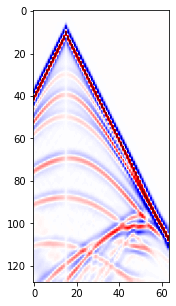

In [4]:
plt.figure(figsize=[7,5])
plt.imshow(d[80], cmap=cmap, vmin=vmin, vmax=vmax)

### Add noise

As we can see from above, the data which you loaded in is the noise-free synthetic. This is great for helping us benchmark the results however we are really interested in testing the denoising performance of blind-trace networks therefore we need to add some trace-wise noise that we wish to later suppress. 

### Patch data

At the moment we have many images that we wish to denoise therefore to train the network we use the whole shots as patches. Shuffling the patches such that they are in a random order. Later at the training stage these patches will be split into train and test dataset.

In [5]:
noisy_patches = add_trace_wise_noise(d,
                                     num_noisy_traces=5,
                                     noisy_trace_value=0.,
                                     num_realisations=7,
                                    )

# Randomise patch order
shuffler = np.random.permutation(len(noisy_patches))
noisy_patches = noisy_patches[shuffler] 

(2828, 128, 64)


#### TO DO: VISUALISE THE TRAINING PATCHES

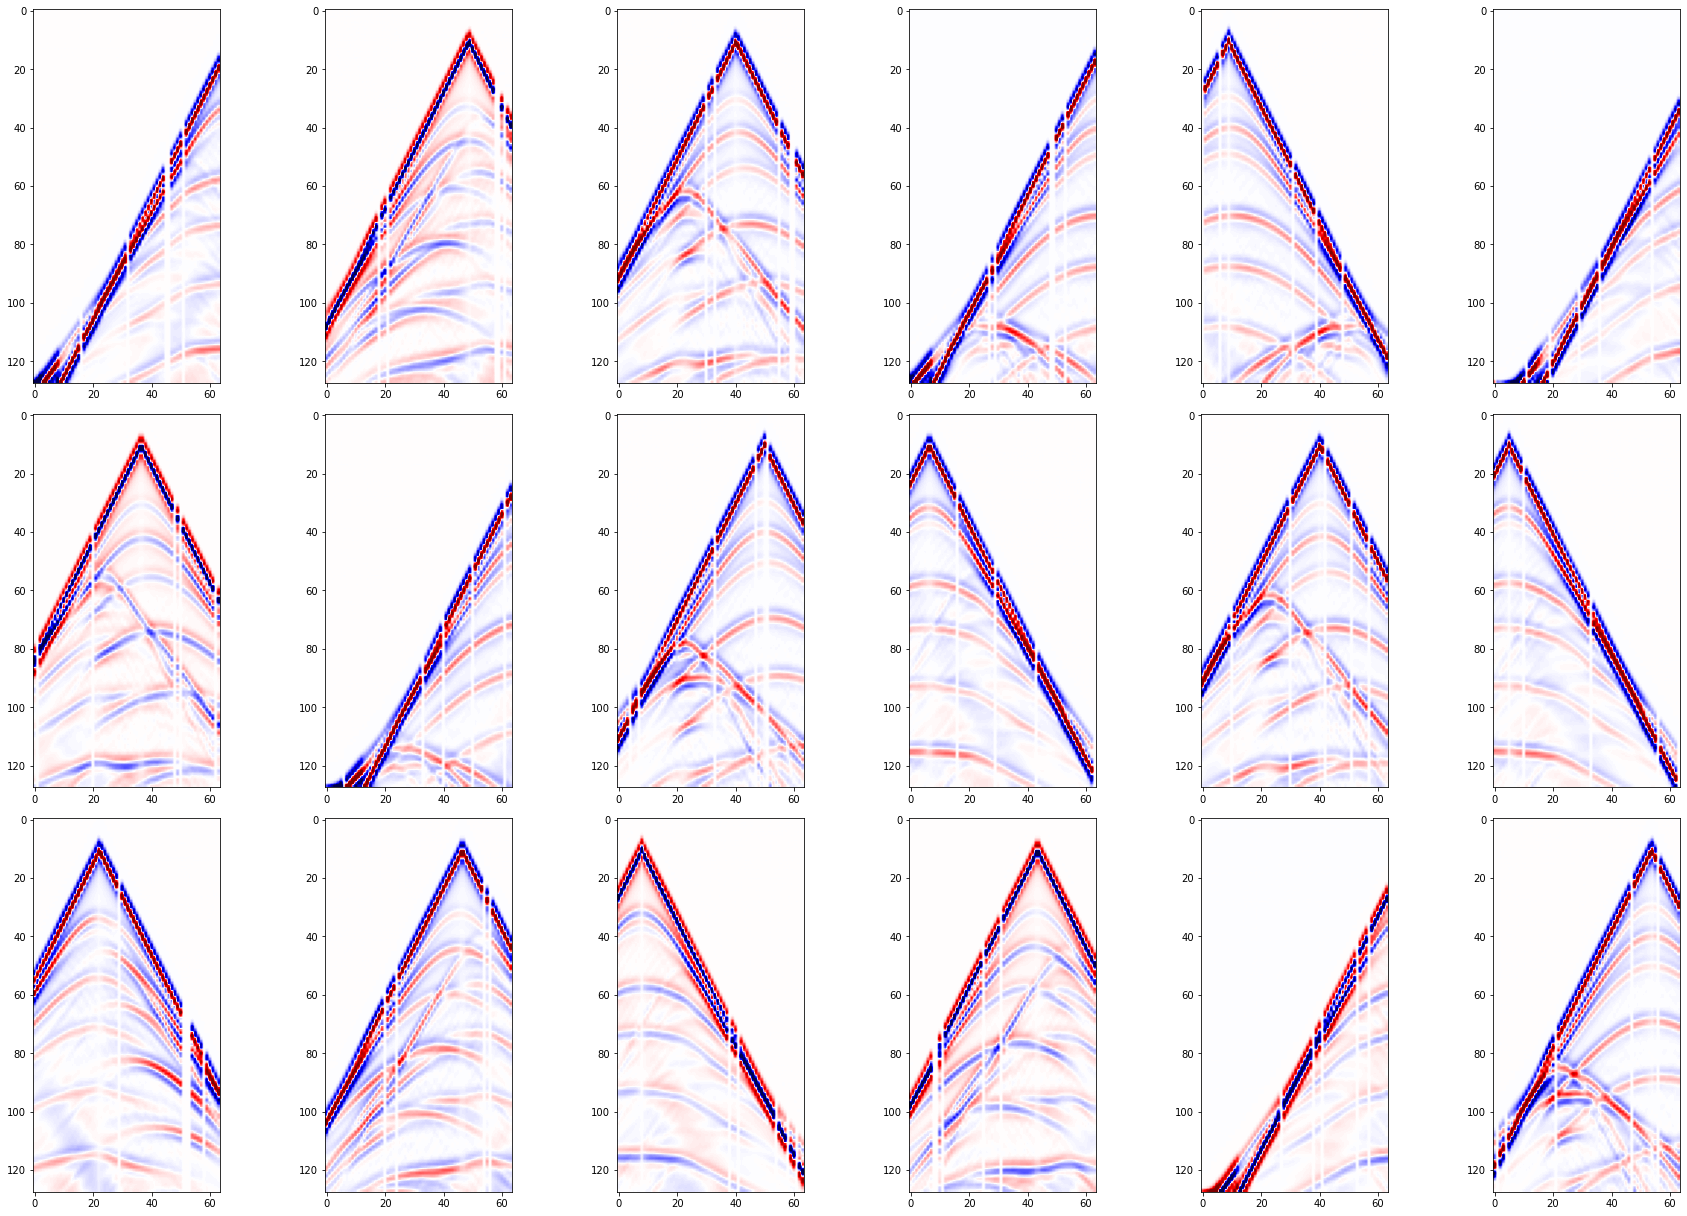

In [6]:
fig, axs = plt.subplots(3,6,figsize=[25,17])
for i in range(6*3):
    axs.ravel()[i].imshow(noisy_patches[i], cmap=cmap, vmin=vmin, vmax=vmax)
fig.tight_layout()

# Step Two - Blindtrace corruption of training data

Now we have made our noisy patches such that we have an adequate number to train the network, we now need to pre-process these noisy patches prior to being input into the network. 

Our implementation of the preprocessing involves:
    - selecting the active pixels 
    - replacing each active pixels' trace with random value from a uniform distribution
    - creating 'mask' which shows the location of the corrupted pixels on the patch
    
The first two steps are important for the pre-processing of the noisy patches, whilst the third step is required for identifying the locations on which to compute the loss function during training.

#### To do: Create a function that randomly selects pixels and corrupts traces following StrucN2V methodology

In [7]:
def multi_active_pixels(patch, 
                        active_number,NoiseLevel,Maskwidth,metrice):
    
    
    """ Function to identify multiple active pixels and replace with values from a random distribution
    
    Parameters
    ----------
    patch : numpy 2D array
        Noisy patch of data to be processed
    active_number : int
        Number of active pixels to be selected within the patch
    NoiseLevel : float
        Random values from a uniform distribution over
        [-NoiseLevel, NoiseLevel] will be used to corrupt the traces belonging to the active pixels 
        to generate the corrupted data
    Maskwidth : int
        The width of the mask for one active pixel    
    metrice: str
        'active' or 'trace', indicate compute the loss function on only the active pixles 
         or the whole masked trace during training
        
    Returns
    -------
        cp_ptch : numpy 2D array
            Processed patch 
        mask : numpy 2D array
            Mask showing location of corrupted traces within the patch 
    """
        
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # STEP ONE: SELECT ACTIVE PIXEL LOCATIONS
    corr=[]                     
    for i in range( active_number*2):
        corr.append(np.random.randint(0,patch.shape[1],1))
    corr=np.array(corr).reshape([active_number,2])    
    
    
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # STEP TWO: REPLACE ACTIVE PIXEL's TRACE VALUES 
    cp_ptch=patch.copy()    
    mix=corr
    for i in range(Maskwidth+1):
        mixcopy=mix.copy()
        mixcopy.T[1]=mix.T[1]-i
        mixcopy = mixcopy.clip(min=np.zeros(2),max=np.array(patch.shape)-1).astype(np.uint)
        cp_ptch[:,tuple( mixcopy.T)[1]] = np.random.rand(patch.shape[0],corr.shape[0])*NoiseLevel*2 - NoiseLevel
       
    for i in range(Maskwidth):
        mixcopy=mix.copy()
        mixcopy.T[1]=mix.T[1]+i+1
        mixcopy = mixcopy.clip(min=np.zeros(2),max=np.array(patch.shape)-1).astype(np.uint)
        cp_ptch[:,tuple( mixcopy.T)[1]] = np.random.rand(patch.shape[0],corr.shape[0])*NoiseLevel*2 - NoiseLevel
    
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # STEP THREE: Make mask and Select metrice for calculating loss 
    mask = np.ones_like(patch)
    if metrice=='active':
            mask[tuple(corr.T)] = 0    
    elif metrice=='trace':
            mask[:,tuple(corr.T)[1]] = 0
    
       
    return cp_ptch, mask

#### TO DO:  CHECK THE CORRUPTION FUNCTION WORKS

In [8]:
# Input the values of your choice into your pre-processing function
crpt_patch, mask = multi_active_pixels(noisy_patches[0], 
                                       active_number=3, 
                                       NoiseLevel=0.5,
                                       Maskwidth=0,
                                       metrice='trace')

Text(0.5, 1.0, 'Corruption Mask')

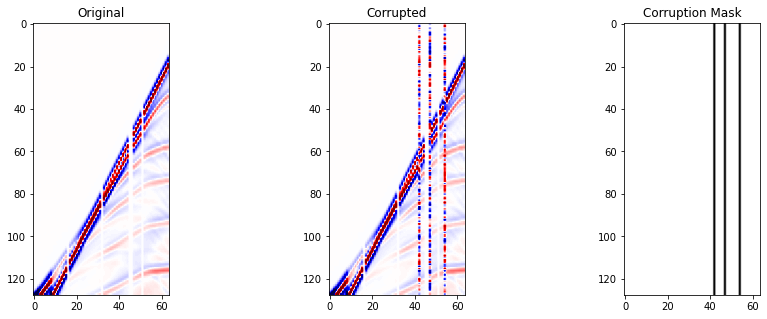

In [9]:
# Use the pre-made plotting function to visualise the corruption
fig,axs = plt.subplots(1,3,figsize=[15,5])
axs[0].imshow(noisy_patches[0], cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].imshow(crpt_patch, cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].imshow(mask, cmap='binary_r')

axs[0].set_title('Original')
axs[1].set_title('Corrupted')
axs[2].set_title('Corruption Mask')

***

# Step three - Set up network

In this example, like in Krull et al., 2018 and Birnie et al., 2021's seismic application, we will use a standard UNet architecture. As the architecture is independent to the blind-spot denoising procedure presented, it will be created via functions as opposed to being wrote within the notebook. 

In [10]:
# Select device for training
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = torch.device(torch.cuda.current_device())
    print(f'Device: {device} {torch.cuda.get_device_name(device)}')
else:
    print("No GPU available!")

Cuda installed! Running on GPU!
Device: cuda:0 NVIDIA Tesla V100-SXM2-32GB


In [11]:
# Build UNet from pre-made function
network = UNet(input_channels=1, 
               output_channels=1, 
               hidden_channels=32,
               levels=2).to(device)
# Initialise UNet's weights from pre-made function
network = network.apply(weights_init) 

/home/lius0e/Transform2022_SelfSupervisedDenoising-main/tutorial_utils.py:267: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight)
/home/lius0e/Transform2022_SelfSupervisedDenoising-main/tutorial_utils.py:268: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)


#### TO DO: SELECT THE NETWORKS TRAINING PARAMETERS

In [12]:
lr = 1e-4   # Learning rate
criterion = nn.L1Loss()  # Loss function
optim = torch.optim.Adam(network.parameters(), betas=(0.5, 0.999),lr=lr)  # Optimiser

***

# Step four - Network Training

Now we have successfully built our network and prepared our data. We are now ready to train the network.

Remember, the network training is slightly different to standard image processing tasks in that we will only be computing the loss on the active pixels.

#### TO DO: DEFINE TRAINING PARAMETERS

In [13]:
# Choose the number of epochs
n_epochs = 20  # most recommend 150-200 for random noise suppression 

# Choose number of training and validation samples
n_training = 2048
n_test = 256

# Choose the batch size for the networks training
batch_size = 32

In [14]:
# Initialise arrays to keep track of train and validation metrics
train_loss_history = np.zeros(n_epochs)
train_accuracy_history = np.zeros(n_epochs)
test_loss_history = np.zeros(n_epochs)
test_accuracy_history = np.zeros(n_epochs)

# Create torch generator with fixed seed for reproducibility, to be used with the data loaders
g = torch.Generator()
g.manual_seed(0)

#### TO DO: INCORPORATE LOSS FUNCTION INTO TRAINING PROCEDURE

In [15]:
def n2v_train(model, 
              criterion, 
              optimizer, 
              data_loader, 
              device):
    """ Blind-spot network training function
    
    Parameters
    ----------
    model : torch model
        Neural network
    criterion : torch criterion
        Loss function 
    optimizer : torch optimizer
        Network optimiser
    data_loader : torch dataloader
        Premade data loader with training data batches
    device : torch device
        Device where training will occur (e.g., CPU or GPU)
    
    Returns
    -------
        loss : float
            Training loss across full dataset (i.e., all batches)
        accuracy : float
            Training RMSE accuracy across full dataset (i.e., all batches) 
    """
    
    model.train()
    accuracy = 0  # initialise accuracy at zero for start of epoch
    loss = 0  # initialise loss at zero for start of epoch

    for dl in tqdm(data_loader):
        # Load batch of data from data loader 
        X, y, mask = dl[0].to(device), dl[1].to(device), dl[2].to(device)
        
        optimizer.zero_grad()
        
        # Predict the denoised image based on current network weights
        yprob = model(X)

        #  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
        # TO DO: Compute loss function only at masked locations and backpropogate it
        # (Hint: only two lines required)
        ls = criterion(yprob * (1 - mask), y * (1 - mask))
        ls.backward()        
        #  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
        
        
        optimizer.step()
        with torch.no_grad():
            yprob = yprob
            ypred = (yprob.detach().cpu().numpy()).astype(float)
            
        # Retain training metrics
        loss += ls.item()  
        accuracy += np.sqrt(np.mean((y.cpu().numpy().ravel( ) - ypred.ravel() )**2))  
        
    # Divide cumulative training metrics by number of batches for training
    loss /= len(data_loader)  
    accuracy /= len(data_loader)  

    return loss, accuracy

#### TO DO: INCORPORATE LOSS FUNCTION INTO VALIDATION PROCEDURE

In [16]:
def n2v_evaluate(model,
                 criterion, 
                 optimizer, 
                 data_loader, 
                 device):
    """ Blind-spot network evaluation function
    
    Parameters
    ----------
    model : torch model
        Neural network
    criterion : torch criterion
        Loss function 
    optimizer : torch optimizer
        Network optimiser
    data_loader : torch dataloader
        Premade data loader with training data batches
    device : torch device
        Device where network computation will occur (e.g., CPU or GPU)
    
    Returns
    -------
        loss : float
            Validation loss across full dataset (i.e., all batches)
        accuracy : float
            Validation RMSE accuracy across full dataset (i.e., all batches) 
    """
    
    model.train()
    accuracy = 0  # initialise accuracy at zero for start of epoch
    loss = 0  # initialise loss at zero for start of epoch

    for dl in tqdm(data_loader):
        
        # Load batch of data from data loader 
        X, y, mask = dl[0].to(device), dl[1].to(device), dl[2].to(device)
        optimizer.zero_grad()
        
        yprob = model(X)

        with torch.no_grad():            
            #  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
            # TO DO: Compute loss function only at masked locations 
            # (Hint: only one line required)
            ls = criterion(yprob * (1 - mask), y * (1 - mask))
            #  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
        
            ypred = (yprob.detach().cpu().numpy()).astype(float)
        
        # Retain training metrics
        loss += ls.item()  
        accuracy += np.sqrt(np.mean((y.cpu().numpy().ravel( ) - ypred.ravel() )**2))  
        
    # Divide cumulative training metrics by number of batches for training
    loss /= len(data_loader)  
    accuracy /= len(data_loader)  

    return loss, accuracy

#### TO DO: COMPLETE TRAINING LOOP BY INCORPORATING ABOVE FUNCTIONS

In [17]:
# TRAINING
for ep in range(n_epochs):  
        
    # RANDOMLY CORRUPT THE NOISY PATCHES
    corrupted_patches = np.zeros_like(noisy_patches)
    masks = np.zeros_like(corrupted_patches)
    for pi in range(len(noisy_patches)):
        
        # TO DO: USE ACTIVE PIXEL FUNCTION TO COMPUTE INPUT DATA AND MASKS
        # Hint: One line of code
        corrupted_patches[pi], masks[pi] = multi_active_pixels(noisy_patches[pi], 
                                                               active_number=15, 
                                                               NoiseLevel=0.25,
                                                               Maskwidth=0,
                                                               metrice='trace')

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # MAKE DATA LOADERS - using pre-made function 
    train_loader, test_loader = make_data_loader(noisy_patches, 
                                                 corrupted_patches, 
                                                 masks, 
                                                 n_training,
                                                 n_test,
                                                 batch_size = 32,
                                                 torch_generator=g
                                                )

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # TRAIN
    # TO DO: Incorporate previously wrote n2v_train function
    train_loss, train_accuracy = n2v_train(network, 
                                           criterion, 
                                           optim, 
                                           train_loader, 
                                           device,)
    # Keeping track of training metrics
    train_loss_history[ep], train_accuracy_history[ep] = train_loss, train_accuracy

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # EVALUATE (AKA VALIDATION)
    # TO DO: Incorporate previously wrote n2v_evaluate function
    test_loss, test_accuracy = n2v_evaluate(network, 
                                            criterion,
                                            optim,
                                            test_loader, 
                                            device,)
    # Keeping track of validation metrics
    test_loss_history[ep], test_accuracy_history[ep] = test_loss, test_accuracy

    
    basedir = os.path.join("./newnet")
    if not os.path.exists(basedir):
        os.makedirs(basedir)
    
    if ep%1==0: 
        mod_name ='denoise_ep%i.net'%ep
        torch.save(network, basedir+'/'+mod_name)
    
    
    
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # PRINTING TRAINING PROGRESS
    print(f'''Epoch {ep}, 
    Training Loss {train_loss:.4f},     Training Accuracy {train_accuracy:.4f}, 
    Test Loss {test_loss:.4f},     Test Accuracy {test_accuracy:.4f} ''')



100%|██████████| 8/8 [00:00<00:00, 28.90it/s]


Epoch 0, 
    Training Loss 0.0076,     Training Accuracy 0.0968, 
    Test Loss 0.0067,     Test Accuracy 0.0788 


100%|██████████| 8/8 [00:00<00:00, 29.50it/s]


Epoch 1, 
    Training Loss 0.0056,     Training Accuracy 0.0630, 
    Test Loss 0.0051,     Test Accuracy 0.0588 


100%|██████████| 8/8 [00:00<00:00, 29.64it/s]


Epoch 2, 
    Training Loss 0.0049,     Training Accuracy 0.0585, 
    Test Loss 0.0049,     Test Accuracy 0.0585 


100%|██████████| 8/8 [00:00<00:00, 29.17it/s]


Epoch 3, 
    Training Loss 0.0047,     Training Accuracy 0.0577, 
    Test Loss 0.0047,     Test Accuracy 0.0574 


100%|██████████| 8/8 [00:00<00:00, 29.59it/s]


Epoch 4, 
    Training Loss 0.0046,     Training Accuracy 0.0572, 
    Test Loss 0.0046,     Test Accuracy 0.0571 


100%|██████████| 8/8 [00:00<00:00, 28.97it/s]


Epoch 5, 
    Training Loss 0.0044,     Training Accuracy 0.0568, 
    Test Loss 0.0045,     Test Accuracy 0.0566 


100%|██████████| 8/8 [00:00<00:00, 29.77it/s]


Epoch 6, 
    Training Loss 0.0043,     Training Accuracy 0.0563, 
    Test Loss 0.0043,     Test Accuracy 0.0557 


100%|██████████| 8/8 [00:00<00:00, 29.92it/s]


Epoch 7, 
    Training Loss 0.0042,     Training Accuracy 0.0554, 
    Test Loss 0.0043,     Test Accuracy 0.0559 


100%|██████████| 8/8 [00:00<00:00, 29.93it/s]


Epoch 8, 
    Training Loss 0.0041,     Training Accuracy 0.0547, 
    Test Loss 0.0040,     Test Accuracy 0.0547 


100%|██████████| 8/8 [00:00<00:00, 29.62it/s]


Epoch 9, 
    Training Loss 0.0039,     Training Accuracy 0.0541, 
    Test Loss 0.0040,     Test Accuracy 0.0540 


100%|██████████| 8/8 [00:00<00:00, 29.45it/s]


Epoch 10, 
    Training Loss 0.0039,     Training Accuracy 0.0535, 
    Test Loss 0.0038,     Test Accuracy 0.0536 


100%|██████████| 8/8 [00:00<00:00, 29.87it/s]


Epoch 11, 
    Training Loss 0.0038,     Training Accuracy 0.0531, 
    Test Loss 0.0038,     Test Accuracy 0.0526 


100%|██████████| 8/8 [00:00<00:00, 29.52it/s]


Epoch 12, 
    Training Loss 0.0037,     Training Accuracy 0.0528, 
    Test Loss 0.0039,     Test Accuracy 0.0530 


100%|██████████| 8/8 [00:00<00:00, 29.88it/s]


Epoch 13, 
    Training Loss 0.0036,     Training Accuracy 0.0525, 
    Test Loss 0.0036,     Test Accuracy 0.0528 


100%|██████████| 8/8 [00:00<00:00, 29.42it/s]


Epoch 14, 
    Training Loss 0.0036,     Training Accuracy 0.0524, 
    Test Loss 0.0035,     Test Accuracy 0.0525 


100%|██████████| 8/8 [00:00<00:00, 29.57it/s]


Epoch 15, 
    Training Loss 0.0035,     Training Accuracy 0.0523, 
    Test Loss 0.0036,     Test Accuracy 0.0524 


100%|██████████| 8/8 [00:00<00:00, 29.54it/s]


Epoch 16, 
    Training Loss 0.0035,     Training Accuracy 0.0523, 
    Test Loss 0.0034,     Test Accuracy 0.0519 


100%|██████████| 8/8 [00:00<00:00, 29.60it/s]


Epoch 17, 
    Training Loss 0.0035,     Training Accuracy 0.0521, 
    Test Loss 0.0034,     Test Accuracy 0.0520 


100%|██████████| 8/8 [00:00<00:00, 29.22it/s]


Epoch 18, 
    Training Loss 0.0034,     Training Accuracy 0.0521, 
    Test Loss 0.0034,     Test Accuracy 0.0522 


100%|██████████| 8/8 [00:00<00:00, 28.89it/s]


Epoch 19, 
    Training Loss 0.0033,     Training Accuracy 0.0519, 
    Test Loss 0.0033,     Test Accuracy 0.0517 


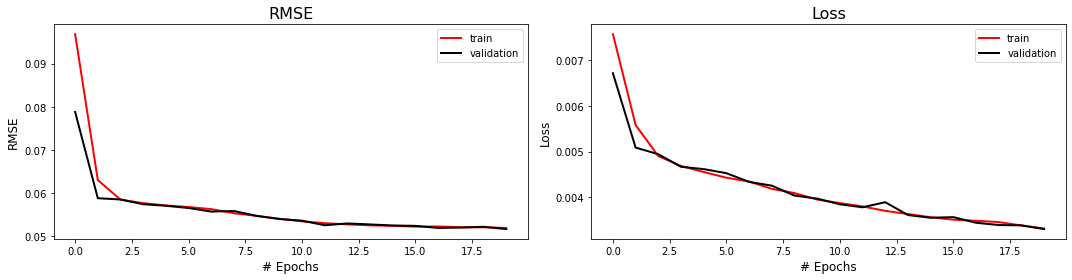

In [18]:
fig,axs = plt.subplots(1,2,figsize=(15,4))

axs[0].plot(train_accuracy_history, 'r', lw=2, label='train')
axs[0].plot(test_accuracy_history, 'k', lw=2, label='validation')
axs[0].set_title('RMSE', size=16)
axs[0].set_ylabel('RMSE', size=12)

axs[1].plot(train_loss_history, 'r', lw=2, label='train')
axs[1].plot(test_loss_history, 'k', lw=2, label='validation')
axs[1].set_title('Loss', size=16)
axs[1].set_ylabel('Loss', size=12)


for ax in axs:
    ax.legend()
    ax.set_xlabel('# Epochs', size=12)
fig.tight_layout()

***

## Step five - Apply trained model

The model is now trained and ready for its denoising capabilities to be tested. 

For the standard network application, the noisy image does not require any data patching nor does it require the active pixel pre-processing required in training. In other words, the noisy image can be fed directly into the network for denoising.

#### TO DO: DENOISE NEW NOISY DATASET

In [19]:
d.shape

(404, 128, 64)

In [20]:
# Make a new noisy realisation so it's different from the training set but with roughly same level of noise
testdata = add_trace_wise_noise(d, 
                                num_noisy_traces=5,
                                noisy_trace_value=0.,
                                num_realisations=1)[80]

testdata.shape

(404, 128, 64)


(128, 64)

FileNotFoundError: [Errno 2] No such file or directory: './newnet/denoise_ep20.net'

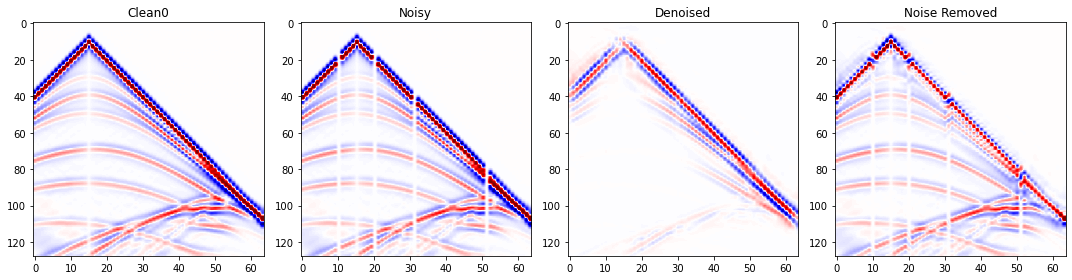

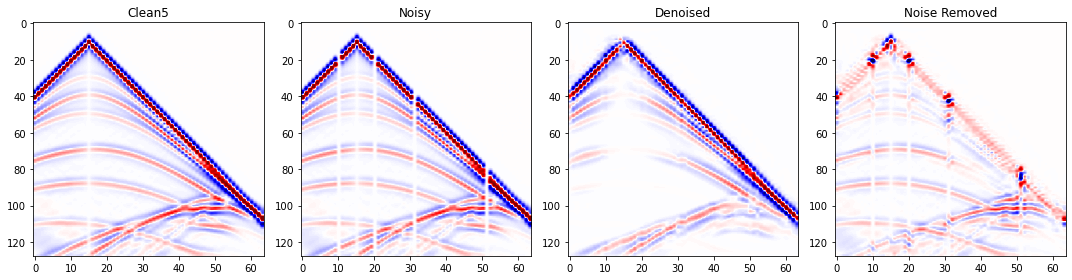

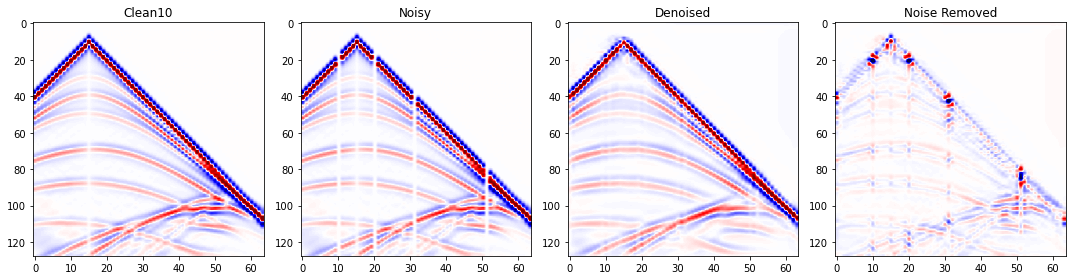

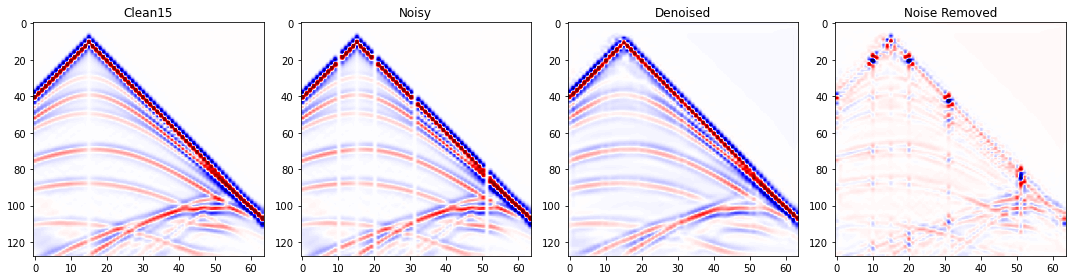

In [22]:
for ep in np.arange(n_epochs+1, step=5):
    
#     netG = UNet(1, 1, 32, 'bnorm').to(device)
#     init_net(netG, init_type='normal', init_gain=0.02, gpu_ids=0)
    netG = UNet(input_channels=1, 
               output_channels=1, 
               hidden_channels=32,
               levels=3).to(device)
    netG=torch.load('./newnet/denoise_ep'+str(ep)+'.net')
    
    
    # Convert dataset in tensor for prediction purposes
    torch_testdata = torch.from_numpy(np.expand_dims(np.expand_dims(testdata,axis=0),axis=0)).float()
    
    # Run test dataset through network
    test_prediction = netG(torch_testdata.to(device))
    
    # Return to numpy for plotting purposes
    test_pred = test_prediction.detach().cpu().numpy().squeeze()
    
    # visualise denoising performance
    fig,axs = plt.subplots(1,4,figsize=[15,4])
    axs[0].imshow(d[80], aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    axs[1].imshow(testdata, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    axs[2].imshow(test_pred, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    axs[3].imshow(testdata-test_pred, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)

    axs[0].set_title('Clean'+str(ep))
    axs[1].set_title('Noisy')
    axs[2].set_title('Denoised')
    axs[3].set_title('Noise Removed')

    fig.tight_layout()